🔍 Extracting features from genre dataset...


Genres:  50%|█████     | 5/10 [01:19<01:16, 15.37s/it]C:\Users\user\AppData\Local\Temp\ipykernel_3652\2965024543.py:15: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, duration=30)
C:\Users\user\AppData\Roaming\Python\Python313\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


⚠️ Error processing F:/projects/personal projects/Music-Genre-classifier/data/genre\jazz\jazz.00054.wav: 


Genres: 100%|██████████| 10/10 [02:25<00:00, 14.54s/it]



🎯 Classification Report:
              precision    recall  f1-score   support

       blues       0.64      0.76      0.70        21
   classical       0.50      1.00      0.67        12
     country       0.80      0.67      0.73        24
       disco       0.58      0.50      0.54        22
      hiphop       0.39      0.60      0.47        15
        jazz       0.68      0.48      0.57        27
       metal       0.65      0.72      0.68        18
         pop       0.65      0.68      0.67        19
      reggae       0.76      0.59      0.67        22
        rock       0.54      0.35      0.42        20

    accuracy                           0.61       200
   macro avg       0.62      0.64      0.61       200
weighted avg       0.64      0.61      0.61       200



C:\Users\user\AppData\Local\Temp\ipykernel_3652\2965024543.py:98: UserWarning: Glyph 127925 (\N{MUSICAL NOTE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


<Figure size 1000x800 with 0 Axes>

C:\Users\user\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127925 (\N{MUSICAL NOTE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


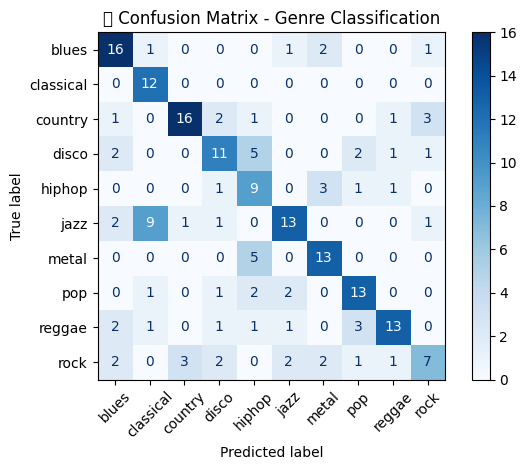

In [15]:
import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm

# --- 1. Extract Features Function ---
def extract_features(file_path):
    try:
        y, sr = librosa.load(file_path, duration=30)
        if len(y) < sr * 5:
            return None

        # Segment the audio to increase precision
        y_segment = y[:sr * 10]

        mfcc = np.mean(librosa.feature.mfcc(y=y_segment, sr=sr, n_mfcc=13).T, axis=0)
        chroma = np.mean(librosa.feature.chroma_stft(y=y_segment, sr=sr).T, axis=0)
        contrast = np.mean(librosa.feature.spectral_contrast(y=y_segment, sr=sr).T, axis=0)
        zcr = np.mean(librosa.feature.zero_crossing_rate(y_segment).T, axis=0)
        tempo, _ = librosa.beat.beat_track(y=y_segment, sr=sr)

        features = np.hstack([mfcc, chroma, contrast, zcr, tempo])
        return features

    except Exception as e:
        print(f"⚠️ Error processing {file_path}: {e}")
        return None

# --- 2. Load and Prepare Data ---
genres_path = "F:/projects/personal projects/Music-Genre-classifier/data/genre"
features, labels = [], []

print("🔍 Extracting features from genre dataset...")
for genre in tqdm(os.listdir(genres_path), desc="Genres"):
    genre_path = os.path.join(genres_path, genre)
    if not os.path.isdir(genre_path):
        continue
    for file in os.listdir(genre_path):
        if file.endswith(".wav"):
            path = os.path.join(genre_path, file)
            data = extract_features(path)
            if data is not None:
                features.append(data)
                labels.append(genre)

features = np.array(features)
labels = np.array(labels)

# --- 3. Encode & Scale ---
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(labels)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# --- 4. Split Data ---
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# --- 5. Hyperparameter Tuning with GridSearchCV ---
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create RandomForest model
model = RandomForestClassifier(random_state=42)

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model after tuning
best_model = grid_search.best_estimator_

# Train on the best model
best_model.fit(X_train, y_train)

# --- 6. Evaluation ---
y_pred = best_model.predict(X_test)
print("\n🎯 Classification Report:")
print(classification_report(y_test, y_pred, target_names=encoder.classes_))

# --- 7. Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)

plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("🎵 Confusion Matrix - Genre Classification")
plt.tight_layout()
plt.show()


In [16]:
# --- 6. Predict Genre of Your Own Songs ---
print("\n🎧 Predicting genres of songs in 'my_songs' folder...")
my_songs_path = "F:/projects/personal projects/Music-Genre-classifier/data/my_songs"
for song in os.listdir(my_songs_path):
    if song.endswith(".wav"):
        song_path = os.path.join(my_songs_path, song)
        feat = extract_features(song_path)
        if feat is not None:
            feat_scaled = scaler.transform([feat])
            pred_index = best_model.predict(feat_scaled)[0]  # use tuned model here
            genre_name = encoder.inverse_transform([pred_index])[0]
            print(f"🎵 {song} → Predicted Genre: {genre_name}")
        else:
            print(f"⚠️ Could not extract features from {song}")



🎧 Predicting genres of songs in 'my_songs' folder...
🎵 cruelsummer.wav → Predicted Genre: hiphop
🎵 lovestory.wav → Predicted Genre: classical
🎵 wannabeslave.wav → Predicted Genre: hiphop
